# Transformermodellen for prediksjon av sekvenser

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import os
# os.environ['NUMBA_DISABLE_JIT'] = '1'
import numpy as np
import matplotlib.pyplot as plt

OPPGAVE 1.1

For å trene en transformermodell så trenger vi et datasett som består at flere x og y vektorer, $ D = \{ (x_0, y_0), (x_1, y_1), \ldots, (x_{n-1}, y_{n-1}) \} $. For å vise et eksempel på et av punktene i datasettet, $(x_0, y_0)$, velger vi $r = 2$, $a = 43$, $b = 7$, $c = 18$ og $d = a \cdot b + c = 319$. Vektoren $x_0$ er bygget opp slik at vi får de $r$ første sifferene av $a$, $b$, $c$ og $d$ og lengden til $x_i$ blir dermed $4 \cdot r$. I dette tilfellet får vi da $x_0 = [4, 3, 0, 7, 8, 3, 1]$. $y_0 $ består av alle sifferene til $d$ og blir her $y_0 = [3, 1, 9]$.  

OPPGAVE 1.2


Vi skal  nå anta at optimeringen er ferdig og at vi har funnet parametrene ${\theta}$ som minimerer objektfunksjonen $\mathscr{L}$, vi skal dermed bruke modellen $f_{\theta}$ til å predikere $d$ gitt $a, b$ og $c$. Modellen $f_{\theta}$ skal testes på en sekvens som bare inneholder tallene til $a, b,$ og $c$ og vi befinner oss i testfasen. I testfasen skal $x\in \mathbb{Z^{2r}}$, ved å kjøre $x$ gjennom modellen skal vi få ut som gir ut $f_{\theta}(x) = \hat{z}$ der $\hat{z}\in \mathbb{Z^{2r}}$, altså vi skal få ut en sekvens av samme dimensjon som sekvensen som puttes inn.

Vi har fortsatt $r = 2$, $a = 43$, $b = 7$ og $c = 18$ og skal predikere $d$. For å predikere $d\in \mathbb{Z^{r+1}}$ skal hver evaluering av modellen predikerer neste sifferet i sekvensen  og legger det til bakerst i $x$, dette blir input neste prediksjon helt til det er predikert $r+1$ nye heltall som ideelt sett skal være lik $d$. 


Vi ønsker å finne ${\theta}$ slik at $\hat{y} = [\hat{z_5}, \hat{z_6}, \hat{z_7}] = [3, 1, 9]$


Vi starter med første sekvens, $x^{(0)} = [4,3,0,7,1,8]$, og setter inn i modellen $f_{\theta}([4,3,0,7,1,8]) = [\hat{z_0}^{(0)}, \hat{z_1}^{(0)},..., \hat{z_5}^{(0)}]$ 

Legger til bakerste siffer fra outputten inn i neste sekvens: $x^{(1)} = [4,3,0,7,1,8, \hat{z_5}^{(0)}]$. Predikerer neste sekvens: $f_{\theta}([4,3,0,7,1,8, \hat{z_5}^{(0)}]) = [\hat{z_0}^{(1)}, \hat{z_1}^{(1)},..., \hat{z_6}^{(1)}]$ 

Gjentar prosessen: $x^{(2)} = [4,3,0,7,1,8, \hat{z_5}^{(0)}, \hat{z_6}^{(1)}]$, $f_{\theta}([4,3,0,7,1,8, \hat{z_5}^{(0)}], \hat{z_6}^{(1)}) = [\hat{z_0}^{(2)}, \hat{z_1}^{(2)},..., \hat{z_7}^{(2)}]$

Etter $3$ evalueringer av modellen ender vi opp med sekvensen: $x^{(3)} = [4,3,0,7,1,8, \hat{z_5}^{(0)}, \hat{z_6}^{(1)}, \hat{z_7}^{(2)}]$

Det er nå predikert $r + 1 = 3$ nye heltall, $\hat{y} = [\hat{z_5}^{(0)}, \hat{z_6}^{(1)}, \hat{z_7}^{(2)}]$. Nå kan vi sammenligneden predikerte $\hat{y}$ med vår $y_0 = [3, 1, 9]$. Dersom vi antar at modellen vår er godt trent skal dette stemme $\hat{z} = \hat{y} = y = [3,1,9]$.

OPPGAVE 1.3

Anta at vi bruker cross-entropy som objektfunksjon, at $m = 5$ og $y = [4, 3, 2, 1]$.

Hvilke diskret sannsynlighetsfordeling $\hat{Y}$ ville gitt en objektfunksjon $\mathscr{L}({\theta},D) = 0 $?

Hva ville ${\hat{y}}$ vært i dette tilfellet?

Ved å bruke cross-entropy funksjonen $\mathscr{L}({\theta},D)$ som loss funksjon og setter denne lik $0$ antar vi at modellen vår er en perfekt prediksjon. Dersom $\hat{Y} = F_{\theta}(x) = onehot(y)$ får vi nettopp dette få $\mathscr{L}({\theta},D) = 0$. Dette betyr også at $\hat{y} = argmax_{col}(F_{\theta}(x))$

Får oppgitt $m = 5$ og $y = [4, 3, 2, 1]$ får vi:

\begin{equation}

onehot(y) = onehot([4, 3, 2, 1]) := \begin{bmatrix} 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 1 \\0 & 0 & 1 & 0 \\ 0 & 1 & 0 & 0 \\ 1 & 0 & 0 & 0 \\\end{bmatrix} = \hat{Y}

\end{equation}

Fordelingen til $\hat{Y}$ tilsvarer en coloumnwise onehot distribution. $1$ representerer den korekte indeksen, ellers er det fyllt med $0$. 
Setter inn for $y$ i $argmax$

$\hat{y} = argmax_{col}(F_{\theta}(x)) = argmax_{col}\begin{bmatrix} 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 1 \\0 & 0 & 1 & 0 \\ 0 & 1 & 0 & 0 \\ 1 & 0 & 0 & 0 \\\end{bmatrix} = [4,3,2,1]$


$F_{\theta}(x)$ tilfredstiller kravene over $m = 5$ utfall og at $\hat{y}$ er en sekvens med lengde $n = 4$ med heltatt opp til $m- 1 = 5 - 1 = 4$



OPPGAVE 1.4

Gitt $d, m, n_{max}, k, p$ og $L$ så skal vi nå beregne hvor mange enkeltparametere, $w \in \mathbb{R}$, vi må bestemme ved optimering. For å finne dette må vi summere opp enkeltparameterene i alle parametermatrisene. Gitt

$\theta = {W_E, W_P, W_U, {{W_O}^{(l)}, {W_V}^{(l)}, {W_Q}^{(l)}, {W_K}^{(l)}, {W_1}^{(l)}, {W_2}^{(l)}}_{l=0}^{L-1}}$

Dimensjonen til $W_E$ og $W_U$ er $d \times m$, dimensjonen til $W_P$ er $d \times n_{max}$ , dimensjonen til ${W_O}^{(l)}, {W_V}^{(l)}, {W_Q}^{(l)}$ og ${W_K}^{(l)}$ er $k \times d$ og dimensjonen til ${W_1}^{(l)}$ og ${W_2}^{(l)}$ er $p \times d$. 

Vi får da totalt $w = 2dm + dn_{max} + (4kd + 2pd) \cdot L$ enkeltparametere som vi kan optimere.

OPPGAVE 1.5

$n = n_{max} = 1$, $m = d = k = p = 2$, $L = 1 \rightarrow l = 0,..., L-1 = 0$ 

$W_{O} = W_{V} = W_{Q} = W_{K} = W_{1} = W_{2} = W_{u} = I_{2x2} = \begin{bmatrix} 1 & 0 \\ 0 & 1\\\end{bmatrix} $

$\sigma(x) = \text{Relu}(x) = \max(0, x)$

$ W_{E} = \begin{bmatrix} 1 & 0 \\ 0 & \alpha \end{bmatrix}$

$ W_{p} = \begin{bmatrix} 1 \\ 0\\\end{bmatrix}$

Skal vise at vi må ha $\alpha > 1$ for å få $\hat{z} = [1]$ som output når input er $x = [1]$

$D\in{\mathbb{R}^{1\times1}}$ er null på øver triangulær inkludert diagonalen, $n = 1$ gir $D = [0]$

##### (4):
I likning $(4)$  $X = onehot(x)$ tar vi inn en vektor $x$ der $x\in{\mathbb{Z}^{1}}$ og får ut en matrise $X$ der $X\in{\mathbb{Z}^{2\times1}}$

$X = onehot([1]) = \begin{bmatrix} 0 \\ 1\\\end{bmatrix}$ $X\in{\mathbb{Z}^{2\times1}}$

##### (5)
I likning $(5)$  $z_{0} = W_{E}X + [W_{p}]_{0:n}$ tar vi inn matrisen $X$ fra likning $(4)$ og får ut en matrise $z_{0}$ der $z_{0}\in{\mathbb{R}^{2 \times 1}}$

$z_{0} = \begin{bmatrix} 1 & 0 \\ 0 & \alpha \\\end{bmatrix} \cdot \begin{bmatrix} 0 \\ 1\\\end{bmatrix} + \begin{bmatrix} 1 \\ 0\\\end{bmatrix} = \begin{bmatrix} 0 \\ \alpha\\\end{bmatrix} + \begin{bmatrix} 0 \\ 1\\\end{bmatrix} = \begin{bmatrix} 1 \\ \alpha\\\end{bmatrix}$

##### (6)
I likning $(6)$  $z_{\frac{1}{2}} = f_{0}^{A}(z_{0}) = z_{0} + W_{0}^{T} W_{V} z_{0} A(z_{0})$ får vi ut en matrise av dimensjon $z_{0}\in{\mathbb{R}^{2 \times 1}}$

For å finne denne må vi første finne Softmax av $z_{0}$ Det gjør vi ved likning (3) $ A(z_{0}) = softmax_{col}(z_{0}^{T} W_{Q}^{T} W_{k} z_{0} + D)$


$A(\begin{bmatrix} 1 \\ \alpha \\\end{bmatrix}) = softmax_{col}(\begin{bmatrix} 1 & \alpha \\\end{bmatrix} \begin{bmatrix} 1 & 0 \\ 0 & 1 \\\end{bmatrix} \begin{bmatrix} 1 & 0 \\ 0 & 1 \\\end{bmatrix} \begin{bmatrix} 1 \\ \alpha\\\end{bmatrix} + [0]) = softmax_{col}(\begin{bmatrix} 1 & \alpha \\\end{bmatrix} \begin{bmatrix} 1 \\ \alpha \\\end{bmatrix} + [0]) = softmax_{col}([\alpha^{2} + 1] + [0]) = softmax_{col}([\alpha^{2} + 1]) = \frac{\exp^{1 + \alpha^2}}{\exp^{1 + \alpha^2}} = 1$

Setter inn in likning (6):


$z_{\frac{1}{2}} = f_{0}^{A}(z_{0}) = \begin{bmatrix} 1 \\ \alpha \\ \end{bmatrix} + \begin{bmatrix} 1&0\\0&1\\\end{bmatrix} \begin{bmatrix} 1&0\\0&1\\\end{bmatrix} \begin{bmatrix} 1 \\ \alpha \\ \end{bmatrix} A(\begin{bmatrix} 1 \\ \alpha \\ \end{bmatrix}) = \begin{bmatrix} 1 \\ \alpha \\ \end{bmatrix} + \begin{bmatrix} 1 \\ \alpha \\ \end{bmatrix} = \begin{bmatrix} 2 \\ 2 \alpha \\ \end{bmatrix}$

##### (7)
I likning $(7)$  $z_{1} = f_{0}^{F}(z_{\frac{1}{2}}) = z_{\frac{1}{2}} + W_{2}^{T} \sigma(W_{1}z_{\frac{1}{2}})$ skal vi få ut en matrise av dimensjon $z_{1}\in{\mathbb{R}^{2\times1}}$

$z_{1} = f_{0}^{F}(z_{\frac{1}{2}}) = \begin{bmatrix} 2 \\ 2 \alpha \\\end{bmatrix} + \begin{bmatrix} 1&0\\0&1\\\end{bmatrix} \sigma (\begin{bmatrix}2\\2\alpha\\\end{bmatrix}) = \begin{bmatrix}2\\2\alpha\\\end{bmatrix} + max(0,\begin{bmatrix}2\\2\alpha\\\end{bmatrix})$

Her får vi to forskjellige utfall:

For $\alpha > 0$ har vi at $\begin{bmatrix}2\\2\alpha\\\end{bmatrix} + max(0,\begin{bmatrix}2\\2\alpha\\\end{bmatrix}) = \begin{bmatrix}2\\2\alpha\\\end{bmatrix} + \begin{bmatrix}2\\2\alpha\\\end{bmatrix} = \begin{bmatrix}4\\4\alpha\\\end{bmatrix}$

For $\alpha < 0$ har vi at $\begin{bmatrix}2\\2\alpha\\\end{bmatrix} + max(0,\begin{bmatrix}2\\2\alpha\\\end{bmatrix}) = \begin{bmatrix}2\\2\alpha\\\end{bmatrix} + \begin{bmatrix}2\\0\\\end{bmatrix} = \begin{bmatrix}4\\2\alpha\\\end{bmatrix}$

##### (8)
I likning $(8)$  $Z = softmax_{col}(W_{U}^{T}z_{L})$ får vi ut en matrise av dimensjon $Z\in{\mathbb{R}^{2\times1}}$

For $\alpha > 0: softmax_{col}(\begin{bmatrix}4\\4\alpha\\\end{bmatrix}) = \begin{bmatrix}  \frac{e^{4}}{e^{4} + e^{4\alpha}} \\  \frac{e^{4\alpha}}{e^{4} + e^{4\alpha}} \\\end{bmatrix}$

For $\alpha < 0: softmax_{col}(\begin{bmatrix}4\\2\alpha\\\end{bmatrix}) = \begin{bmatrix} \frac{e^{4}}{e^{4} + e^{2\alpha}} \\ \frac{e^{2\alpha}}{e^{4} + e^{2\alpha}} \\\end{bmatrix}$

##### (9)
I likning $(9)$ $\hat{z} = argmax_{col}(Z)$ får vi ut $\hat{z}\in(\mathbb{Z}^{1})$

For $\alpha > 0: argmax_{col}(\begin{bmatrix}  \frac{e^{4}}{e^{4} + e^{4\alpha}} \\  \frac{e^{4\alpha}}{e^{4} + e^{4\alpha}} \\\end{bmatrix})$

For $\alpha < 0: argmax_{col}(\begin{bmatrix}  \frac{e^{4}}{e^{4} + e^{2\alpha}} \\  \frac{e^{2\alpha}}{e^{4} + e^{2\alpha}} \\\end{bmatrix})$

For at $\hat{z} = 1$ må vi ha at det nederste elementet i vektoren være størst, altså:
$\frac{e^{4\alpha}}{e^{4} + e^{4\alpha}} > \frac{e^{4}}{e^{4} + e^{4\alpha}}$ $\rightarrow$ $\alpha > 1$

For det andre tilfelle får vi at $\alpha > 2$, men vi har bestemt fra før at $\alpha < 0$, vi får dermed $L = Ø$
Vi har dermed at $\alpha > 1$ for at $\hat{z} = 1$ $\blacksquare$


#### Oppgave 3.2
Printer gjennomsnittet av objektfunskjonen(losset) over batchene :
$\mathscr{L}^{j} = \frac{1}{B}  \sum_{k=0}^{B-1}\mathscr{L}^{j}_{k}$

Losset skal bli mindre for hver iterasjon

Training model: 100%|██████████| 100/100 [00:57<00:00,  1.75it/s, loss=1.16, accuracy=0.451]


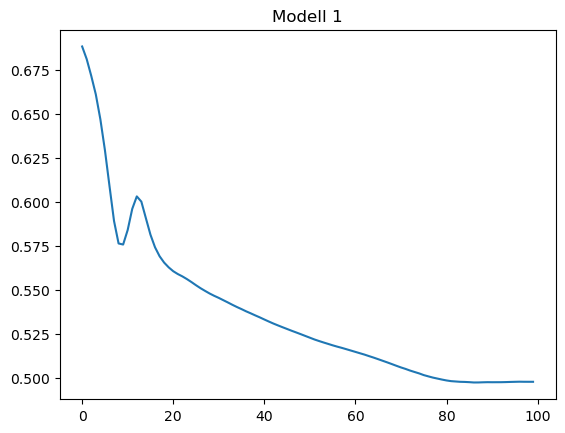

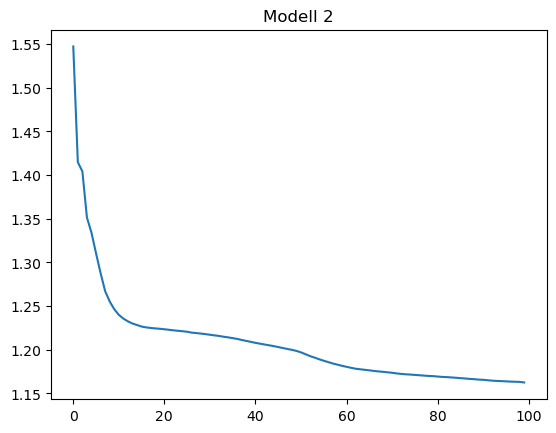

In [17]:
import importlib
import training
importlib.reload(training)
from training import make_model, training_sorting
from layers import CrossEntropy
from optimizer import Adam
from data_generators import get_train_test_sorting, get_train_test_addition

n = 100

test_model_1 = make_model(r=5, d=10, m=2, L=2, p=15, k=5)
test_model_2 = make_model(r=7, d=20, m=5, L=2, p=25, k=10)

sorting_data1 = get_train_test_sorting(5, 2, 400, 10, 10)
trained_model1, mean_loss_arr = training_sorting(test_model_1, CrossEntropy(), Adam(), sorting_data1, 2, n_epochs=n)

sorting_data2 = get_train_test_sorting(7, 5, 300, 20, 20)
trained_model2, mean_loss_arr2 = training_sorting(test_model_2, CrossEntropy(), Adam(), sorting_data2, 5, n_epochs=n)

iter = np.arange(n)

plt.title("Modell 1")
plt.plot(iter, mean_loss_arr)
plt.show()
plt.title("Modell 2")
plt.plot(iter, mean_loss_arr2)
plt.show()

In [18]:
from testing import test_sorting
import importlib
import testing

accuracy1 = test_sorting(trained_model1, sorting_data1, m=2)
print(f'Accuracy for model 1: {accuracy1}')

accuracy2 = test_sorting(trained_model2, sorting_data2, m=5)
print(f'Accuracy for model 2: {accuracy2}')

Y PRED SHAPE:
(400, 2, 5)
Y TEST SHAPE:
(10, 400, 5)
Y PRED SHAPE:
(400, 2, 5)
Y TEST SHAPE:
(10, 400, 5)
Y PRED SHAPE:
(400, 2, 5)
Y TEST SHAPE:
(10, 400, 5)
Y PRED SHAPE:
(400, 2, 5)
Y TEST SHAPE:
(10, 400, 5)
Y PRED SHAPE:
(400, 2, 5)
Y TEST SHAPE:
(10, 400, 5)
Y PRED SHAPE:
(400, 2, 5)
Y TEST SHAPE:
(10, 400, 5)
Y PRED SHAPE:
(400, 2, 5)
Y TEST SHAPE:
(10, 400, 5)
Y PRED SHAPE:
(400, 2, 5)
Y TEST SHAPE:
(10, 400, 5)
Y PRED SHAPE:
(400, 2, 5)
Y TEST SHAPE:
(10, 400, 5)
Y PRED SHAPE:
(400, 2, 5)
Y TEST SHAPE:
(10, 400, 5)
Accuracy for model 1: 49.64


AssertionError: 

In [11]:
importlib.reload(training)
from training import make_model, training_addition

n = 100

test_model_add = make_model(r=2, d=30, m=10, L=3, p=40, k=20)
addition_data = get_train_test_addition(n_digit=2, samples_per_batch=50, n_batches_train=20, n_batches_test=20)

trained_model_add, mean_loss_arr_add = training_addition(test_model_add, CrossEntropy(), Adam(), addition_data, 10, n_epochs=n, r=2)

iter = np.arange(n)

plt.title("Addition loss")
plt.plot(iter, mean_loss_arr_add)
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]


ValueError: unable to broadcast argument 1 to output array
File "/Users/hanna/Library/CloudStorage/OneDrive-NTNU/TMA4320 - Vitber/Vitber-indmat-8/layers.py", line 1, 